<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Taller_7/Taller_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219
Primer semestre - 2024

## Taller 7

**Integrante 1:**

**Integrante 2:**


Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

Los datos se encuentran en el siguiente enlace: https://www.dropbox.com/scl/fi/qh6dk5qch11rfuz9hmptm/Data.zip?rlkey=wdteinhhad7s6j5okq0bjosvq&dl=0

NOTA: El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreCompleto_Taller7.ipynb

In [ ]:
# for data input and output:
import numpy as np
import os
# for deep learning:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape # new!
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D #new!
from tensorflow.keras.optimizers import RMSprop # new!
# for plotting:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [ ]:
# Estamos suponiendo que estan realizando el Taller en colab, y subieron los datasets a su drive.
# Si estan en la MV suministrada para el proyecto, las instrucciones de montar el drive no son necesarias.
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
# Carpeta en colab donde estan los archivos
%cd /content/drive/MyDrive/Laboratorio MLT/Laboratorio 12

/content/drive/MyDrive/Laboratorio MLT/Laboratorio 13


## Dataset:
Para este ejercicio se usará el dataset de quickdraw(https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap;tab=objects?prefix=&forceOnObjectsSortingFiltering=false) el cual se crea a partir de imagenes dibujadas por usuarios en la aplicacion quickdraw de google(https://quickdraw.withgoogle.com/)

In [ ]:
input_images = "donut.npy"
data = np.load(input_images)


In [ ]:
data = data/255 #Al dividir por 255 es calamos los pixeles entre un rango de 0 y 1

#Se realiza un reshape de la imagen, donde el primer elemento corresponde al
#batch(Longitud del dataset), el segundo y tercer elemento corresponden a la dimensión de la imagen
#y el tercer elemento es el numero de canales, el cual es 1 para imágenes monocromáticas y 3 para imágenes a color
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]


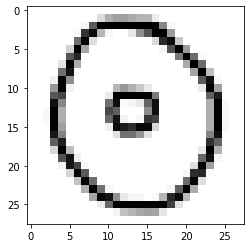

In [ ]:
#se imprime una de las imágenes.
# Recordar que el primer elemento corresponde a la imagen en cuestion que en este caso es la 241,
# Los siguientes dos usamos ':' para decir que nos imprima todos los elementos, en este caso corresponde a las dimensiones
# de la imagen y el cero del final corrresponde al canal, que como solo tiene 1 dimensión se coloca cero para tomar ese valor
plt.imshow(data[241,:,:,0], cmap='Greys')

In [ ]:
'''
Contrumios el discriminador, el cual nos ayuda a clasificar si la imagen en cuestión es falsa o verdadera
para este ejemlo implementamos 4 capas convolucionales que van aumentando el numero de filtros de forma progresiva
al final termina con una capa densa de una neurona y activacion sigmoidal para realizar la clasificación.
'''
def build_discriminator(depth=64, p=0.3):
    # Se define las dimensiones de entrada (28,28,1)
    image = Input((img_w,img_h,1))

    #Capas convolucionales
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    conv2 = Conv2D(depth*2, 5, strides=2,padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    conv3 = Conv2D(depth*4, 5, strides=2,padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    conv4 = Conv2D(depth*8, 5, strides=1,padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))

    # Capa de salida
    prediction = Dense(1, activation='sigmoid')(conv4)

    # definición del modelo
    model = Model(inputs=image, outputs=prediction)
    return model

In [ ]:
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0008), metrics=['accuracy'])

discriminator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0     

In [ ]:
z_dimensions = 32 #Se especifica el número de dimensiones en el vector de ruido de entrada
'''
El generador es el elemento de la GAN que nos permite generar imagenes a partir de un vector de ruido
'''
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
    # Define inputs
    noise = Input((latent_dim,))

    '''
    La primera capa oculta es una capa densa. Esta capa permite que la entrada
    del espacio latente se mapee de manera flexible a las capas ocultas espaciales (desconvolucionales)
    que siguen. Las 32 dimensiones de entrada se asignan a 3136(7*7*64) neuronas en la capa densa, que genera una matriz
    unidimensional de activaciones. Estas activaciones luego se reforman en un mapa de activación de 7×7×64.
    '''
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # nos ayuda a normalizar las salidas de la capas
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # De-Convolutional layers
    '''
    La red tiene tres capas desconvolucionales (especificadas por Conv2DTranspose).
    El primero tiene 32 filtros, y este número se reduce a la mitad sucesivamente en
    las dos capas restantes. Mientras que el número de filtros disminuye, el tamaño de
    los filtros aumenta, gracias a las capas de muestreo ascendente (UpSampling2D).
    Cada vez que se aplica upsampling (con sus parámetros predeterminados),
    tanto la altura como el ancho del mapa de activación se duplican.
    '''
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    # Model definition
    model = Model(inputs=noise, outputs=image)
    return model


In [ ]:
generator = build_generator()


In [ ]:
#observar las dimensiones de salida despues de cada capa
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

In [ ]:
#Para probar el generados creamos un vetor de ruido con distrubucion normal
#lo ingresamos al generador
noise_vector = np.random.normal(size=(z_dimensions,1))
noise_image = generator.predict(noise_vector.T)

1/1 [==============================] - 1s 555ms/step


Dimensiones antes de implementar squeeze: (1, 28, 28, 1)
Dimensiones despues de implementar squeeze: (28, 28)




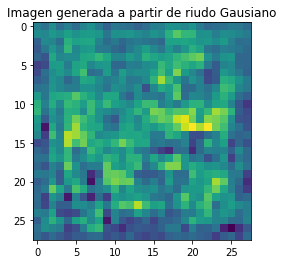

In [ ]:
#Mostra la imagen que se genera a parir del ruido
# squeeze procesa el tensor y quita las dimensiones iguales a 1 como se muestra a continuación:
print(f'Dimensiones antes de implementar squeeze: {noise_image.shape}')
print(f'Dimensiones despues de implementar squeeze: {noise_image.squeeze().shape}')
print('\n')
plt.imshow(noise_image.squeeze())
plt.title('Imagen generada a partir de riudo Gausiano')
plt.show()

In [ ]:
'''
Usamos Input() para definir la entrada z del modelo, que será una matriz de ruido aleatorio de longitud 32.
'''
z = Input(shape=(z_dimensions,))

'''Pasar z al generador devuelve una salida de imagen de 28 × 28.'''
img = generator(z)

''' Al momento de entrenar el generador, los parámetros del discriminador
deben congelarse, por lo que establecemos
el atributo entrenable del discriminador en Falso.'''
discriminator.trainable = False

'''Pasamos la imagen falsa a la red discriminadora congelada,
que emite una predicción sobre si la imagen es real o falsa.'''
pred = discriminator(img)

'''utilizando la clase Model, construimos
el modelo adversario. Al indicar que la entrada del modelo adversario
es z y su salida es la prediccion(pred), al final se determina que la red adversaria
consiste en que el generador pasa img al discriminador congelado.'''
adversarial_model = Model(z, pred)

adversarial_model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0004), metrics=['accuracy'])



La siguiente imagen representa como es el proceso de entrenamiento para cada uno de los componentes de las redes adversarias generativas:
![img](https://drive.google.com/uc?export=view&id=17anS-D02LHqFMsgzXpc3dtNwvWzktbBU)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Epoch #199
199: [D loss: 0.2263182, acc:0.9531250] [A loss: 2.0690842, acc: 0.0156250]
1/1 [==============================] - 0s 65ms/step


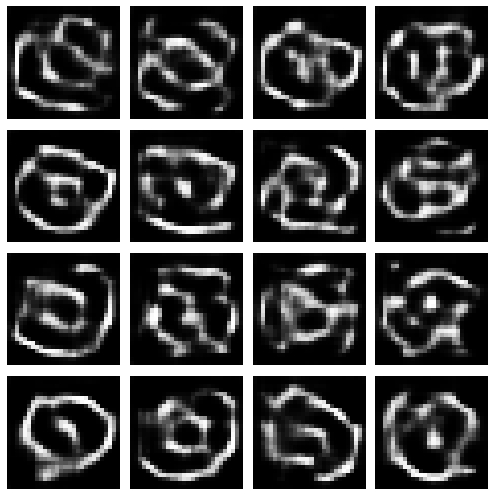

200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
Epoch #399
399: [D loss: 0.2430848, acc:0.8671875] [A loss: 3.9678741, acc: 0.0312500]
1/1 [==============================] - 0s 61ms/step


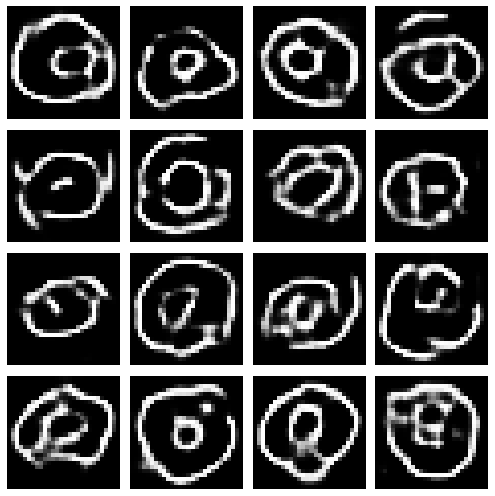

400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
Epoch #599
599: [D loss: 0.4218923, acc:0.8125000] [A loss: 1.8040743, acc: 0.2187500]
1/1 [==============================] - 0s 64ms/step


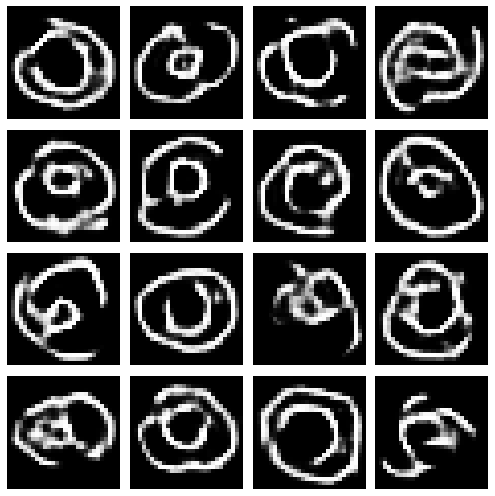

600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
Epoch #799
799: [D loss: 0.2632333, acc:0.8984375] [A loss: 3.9897580, acc: 0.0000000]
1/1 [==============================] - 0s 58ms/step


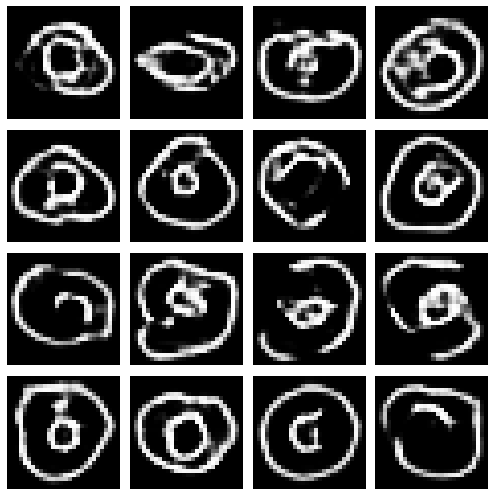

800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
Epoch #999
999: [D loss: 0.2021189, acc:0.9062500] [A loss: 4.0531311, acc: 0.0312500]
1/1 [==============================] - 0s 61ms/step


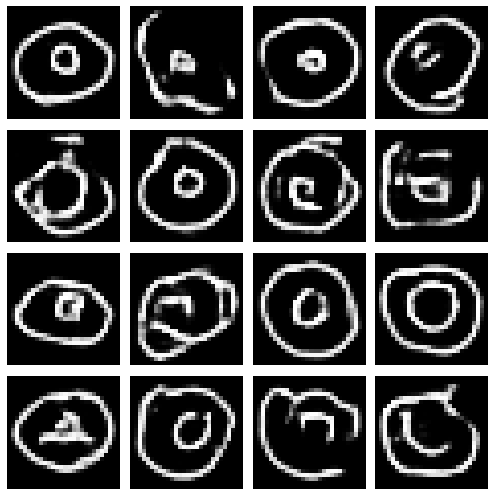

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


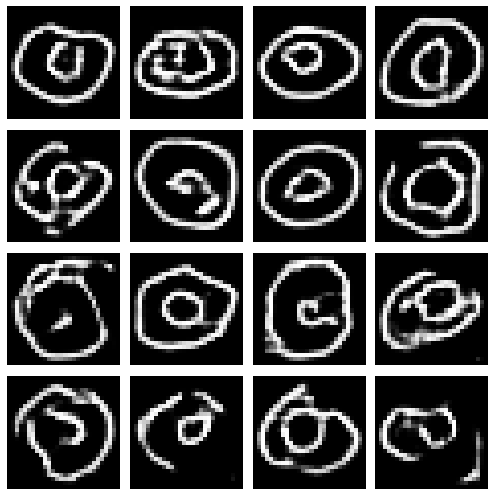

1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399


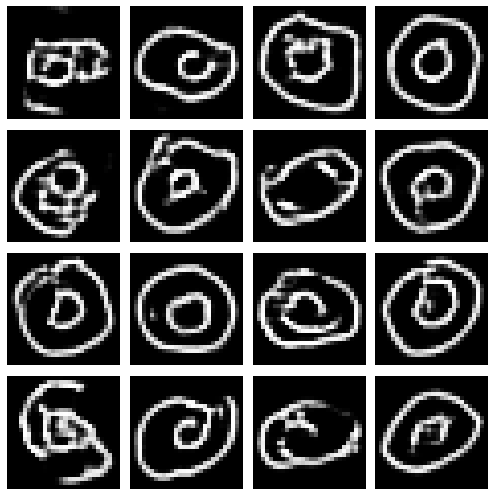

1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599


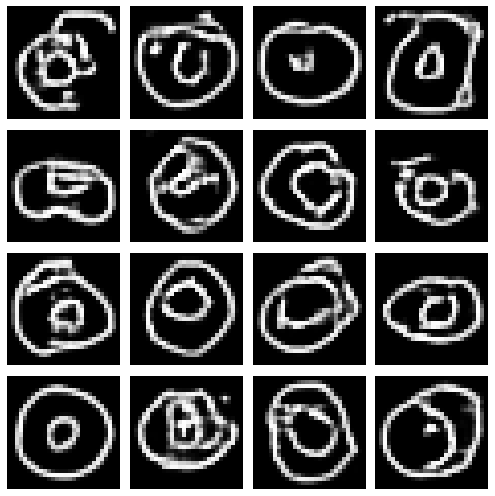

1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799


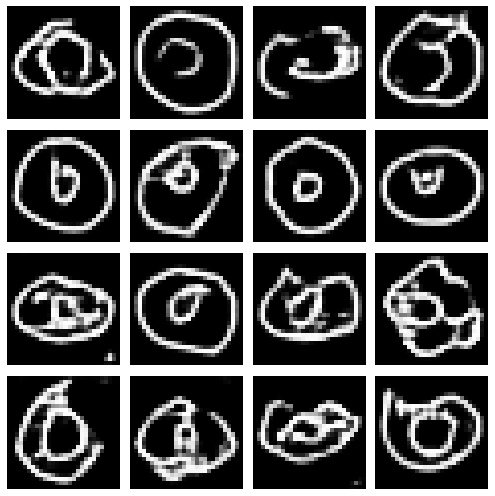

1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


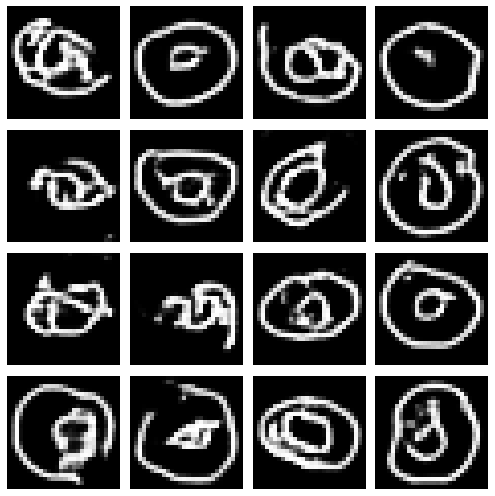

In [ ]:
def train(epochs=2000, batch=64, z_dim=z_dimensions):
    d_metrics = []
    a_metrics = []
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    for i in range(epochs):
        print(i)
        # Muestra un batch de 64 imágenes reales seleccionadas de forma aleatoria, se ñe hace un reshape.
        real_imgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch,28,28,1))

        '''Generar 64(batch) imágenes falsas creando vectores de ruido (z, muestreados uniformemente en el rango [–1:0, 1:0])
         y pasándolos al método 'predict' del modelo generador. Tenga en cuenta que al usar el método de predicción,
          el generador solo está generando imágenes sin actualizar ninguno de sus parámetros.'''
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]), verbose=0)

        '''Se concatenan las imágenes reales y falsas en una sola variable x, que servirá como entrada en nuestro discriminador.'''
        x = np.concatenate((real_imgs,fake_imgs))

        ''' Cree una matriz, y, para etiquetar las imágenes como reales (y = 1) o falsas (y = 0)
        para que puedan usarse para entrenar al discriminador.'''
        y = np.ones([2*batch,1]) # se usa 2*batch ya que son 64(1 batch) reales y 64(1 batch) falsas
        y[batch:,:] = 0 # se agrga la etiqueta 0 a las imagenes falsas

        # train discriminator:
        '''Para entrenar al discriminador, pasamos nuestras entradas X y etiquetas Y al método train_on_batch del modelo.'''
        d_metrics.append(discriminator.train_on_batch(x,y)) #train_on_batch : Ejecuta una única actualización de gradiente en un único batch de datos.
        '''Después de cada ronda de entrenamiento, las métricas de loss
        y accuracy del entrenamiento se agregan a la lista d_metrics'''
        running_d_loss += d_metrics[-1][0] #Se suman los valores de perdida en cada epoca del discriminador
        running_d_acc += d_metrics[-1][1] #Se suman los valores de accuracy en cada epoca del discriminador

        # adversarial net's noise input and "real" y:
        '''Se pasan vectores de ruido aleatorio como entradas,
        así como una matriz (y) de etiquetas totalmente reales (es decir, y = 1)
          al método train_on_batch del modelo contradictorio.'''
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        y = np.ones([batch,1])

        # train adversarial net:
        '''El componente generador del modelo adversario convierte las entradas
        de ruido en imágenes falsas, que se pasan automáticamente como entradas al
        componente discriminador del modelo adversario. Debido a que los parámetros
        del discriminador se congelan durante el entrenamiento del modelo adversario,
        el discriminador simplemente nos dirá si cree que las imágenes entrantes son
        reales o falsas. Aunque el generador genera falsificaciones, se etiquetan
        como reales (y = 1) y cross-entropy loss se usa durante la retropropagación
        para actualizar los pesos del modelo del generador. Al minimizar este costo,
        el generador debe aprender a producir imágenes falsas que el discriminador
        clasifica erróneamente como reales.'''
        a_metrics.append(adversarial_model.train_on_batch(noise,y))

        running_a_loss += a_metrics[-1][0] #Se suman los valores de perdida en cada epoca de la red adversa
        running_a_acc += a_metrics[-1][1] #Se suman los valores de accuracy en cada epoca de la red adversa

        # periodically print progress & fake images:
        if (i+1)%200== 0:
            #Se imprimen los valores de las metricas
            print(f'Epoch #{i}')
            log_mesg = f"{i}: [D loss: {(d_metrics[-1][0]):.7f}, acc:{(d_metrics[-1][1]):.7f}]"
            log_mesg = f"{log_mesg} [A loss: {(a_metrics[-1][0]):.7f}, acc: {(a_metrics[-1][1]):.7f}]"
            print(log_mesg)

            #Se generan 16 imagenes a partir de vectores de riudo usando el generador previamente entrenado
            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])
            gen_imgs = generator.predict(noise)
            plt.figure(figsize=(7,7))
            plt.title(f'Imagenes generadas epoca #{i}')

            for k in range(gen_imgs.shape[0]):
                #plt.figure(figsize=(7,7))
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()

            plt.savefig(f'imagnes_epoch_{i}.png') #guardamos las imagenes
            plt.show()

            generator.save(f'chkpt/generator_epoch_{i}.h5') #guardamos el modelo
    return a_metrics, d_metrics

# train the GAN:
a_metrics_complete, d_metrics_complete = train()



In [ ]:
#Se guardan las métricas previamente obtenidas para ser usadas posteriormente de ser necesario
a_metrics_full = np.array(a_metrics_complete)
d_metrics_full = np.array(d_metrics_complete)

np.save('a_metrics.npy', a_metrics_full)
np.save('d_metrics.npy', d_metrics_full)

Text(0, 0.5, 'Loss')

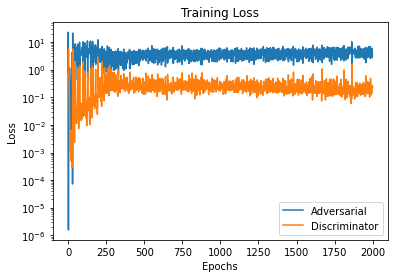

In [ ]:
ax = pd.DataFrame({
    'Adversarial': [metric[0] for metric in a_metrics_full],
    'Discriminator': [metric[0] for metric in d_metrics_full]}).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
#cargamos el modelo pre-entrenado previamente y realizamos una predicción
gene  = tf.keras.models.load_model('chkpt/generator_epoch_1999.h5')
noise = np.random.uniform(-1.0, 1.0, size=(1,32))

1/1 [==============================] - 0s 189ms/step


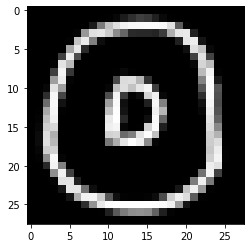

In [ ]:
#observamos que a partir de ruido nuestro generados fue capas de recrear una donut
plt.imshow(gene.predict(noise).squeeze(), cmap='gray')
plt.show()

# Desarrollo del taller:
Antes de iniciar el taller se recomienda leer y entender el desarrollo del ejemplo previo.
1. Seleccionar de la carpeta datasets 2 datasets.
2. Realizar cambios en la arquitectura del generador y discrimidanor. Investigar arquitecturas usadas o implementar una propia
3. Entrenar el modelo, observar cada 200 epocas el cambio en las imágenes que produce en generador. NOTA: Aumentar el numero de epocas ya que las imágenes a generar son mas 'complejas' a la del ejemplo, las imágenes del progreso del generador se deben mostrar en el notebook.
4. Graficar el comportamiento de la perdida del discriminador y la red adversa a traves de las epocas de entrenamiento
5. Generar una imagen a partir de ruido con el modelo previamente entrenado

NOTA: En google colab, usando la CPU el modelo se demora aproximadamente 1h10 min por cada 1000 epocas. Tenerlo en cuenta para el desarrollo del taller y no tener problemas con el tiempo